
# Workshop Example: Predicting Ion Concentrations in Delta

**Disclaimer:** This notebook is created for educational purposes as part of a machine learning workshop. The models and methods demonstrated here are simplified examples and not necessarily optimized for production use. The actual models used in production environments may incorporate additional features, more sophisticated techniques, and more extensive validation.

In this workshop, we'll walk through a machine learning workflow using water ion data from the California Delta. We'll focus on predicting Bromine (Br) concentration based on various predictors including both numerical variables (like Electrical Conductivity) and categorical variables (like location and water year type).

### Workflow Overview:
1. **Data Loading**: Import and initial processing of water quality datasets
2. **Data Visualization**: Explore relationships between variables
3. **Preprocessing**: Feature engineering, scaling, and encoding
4. **Model Training**: Implement and train multiple models (Random Forest, XGBoost, Neural Network)
5. **Model Evaluation**: Compare performance across models
6. **Interactive Dashboard**: Create a user-friendly interface for predictions

This example demonstrates how machine learning can be applied to environmental data to create predictive tools that support water management decision-making.
**For questions or feedback, please contact:**  
Peyman Namadi (peyman.hosseinzadehnamadi@water.ca.gov)

## Section 0: Setup and Library Imports

In [ ]:
!pip install hvplot holoviews panel
!pip install jupyter_bokeh

In [2]:
# ================= SECTION 0: IMPORT LIBRARIES =================
# Core data handling and analysis
import pandas as pd
import numpy as np
import os
import joblib
from datetime import datetime

# Visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv
import panel as pn

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set default styles for visualizations
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})

## 1. Data Loading

In [ ]:
import pandas as pd
import os
import numpy as np
from datetime import datetime

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update paths to point to your Drive locations
input_folder = '/content/drive/MyDrive/WorkshopML_Colab/inputs'
output_folder = '/content/drive/MyDrive/WorkshopML_Colab/outputs'

# Make sure the output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created output directory: {output_folder}")

# List of ion files to load
ions = ['Alkalinity', 'Br', 'Ca', 'Cl', 'K', 'Mg', 'Na', 'SO4', 'TDS']
ion_dfs = {}

# Load each ion dataset from CSV
for ion in ions:
    # Construct the file path
    file_path = os.path.join(input_folder, f"{ion}.csv")

    # Load the CSV if it exists
    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)
        print(f"Loaded {ion} dataset: {df.shape[0]} rows, {df.shape[1]} columns")

        # Convert Collection Date to datetime
        df['Collection Date'] = pd.to_datetime(df['Collection Date'])

        # Set categorical variables
        if 'Location' in df.columns:
            df['Location'] = df['Location'].astype('category')
        if 'WYT' in df.columns:
            df['WYT'] = df['WYT'].astype('category')

        # Store in both a dictionary and as a global variable with the same name as the ion
        ion_dfs[ion] = df
        globals()[ion] = df
    else:
        print(f"Warning: Could not find {file_path}")

Mounted at /content/drive
Loaded Alkalinity dataset: 1039 rows, 7 columns
Loaded Br dataset: 1239 rows, 7 columns
Loaded Ca dataset: 1335 rows, 7 columns
Loaded Cl dataset: 1972 rows, 7 columns
Loaded K dataset: 1148 rows, 7 columns
Loaded Mg dataset: 1336 rows, 7 columns
Loaded Na dataset: 1575 rows, 7 columns
Loaded SO4 dataset: 1072 rows, 7 columns
Loaded TDS dataset: 1466 rows, 7 columns


## 2. Visualization

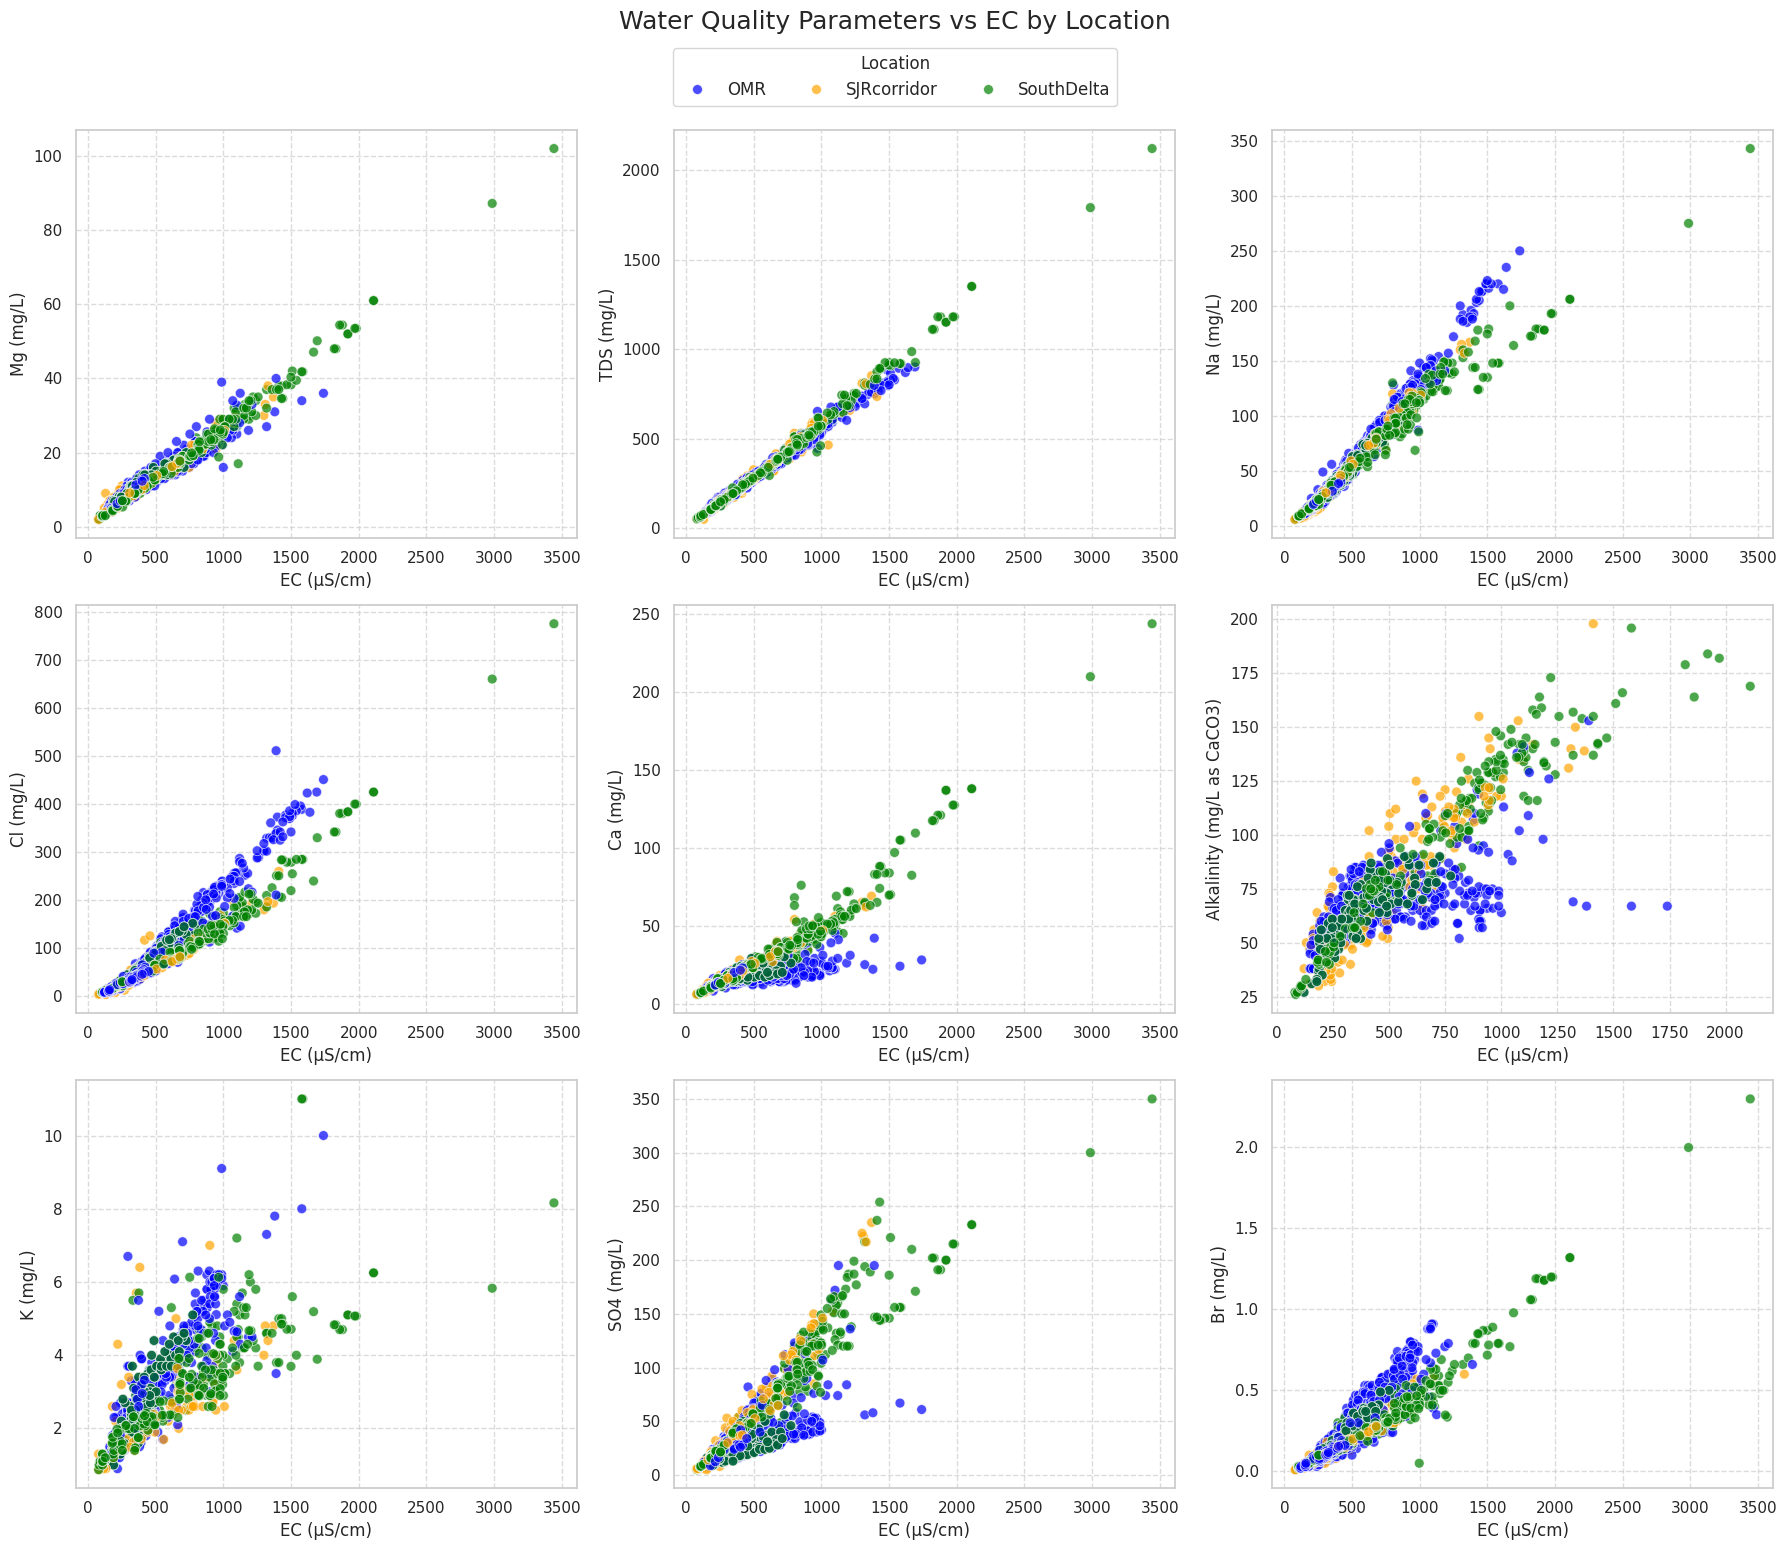

In [ ]:
# Set the visualization style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})

# Define the ions and their units for plotting
ions_info = {
    'Mg': 'mg/L',
    'TDS': 'mg/L',
    'Na': 'mg/L',
    'Cl': 'mg/L',
    'Ca': 'mg/L',
    'Alkalinity': 'mg/L as CaCO3',  # Changed from CaCO₃ to CaCO3 to avoid font issues
    'K': 'mg/L',
    'SO4': 'mg/L',
    'Br': 'mg/L'
}

# Plotting order (same as ions_info keys, but explicit for clarity)
plot_order = list(ions_info.keys())

# Colors for different locations in the Delta
location_colors = {'OMR': 'blue', 'SJRcorridor': 'orange', 'SouthDelta': 'green'}

# Create a figure with 9 subplots (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()  # Convert 2D array of axes to 1D for easier indexing

# Create a scatter plot for each ion
for i, ion in enumerate(plot_order):
    ax = axes[i]  # Get the current subplot
    df = ion_dfs[ion]  # Get the dataframe for this ion

    # Check if the dataframe has all the necessary columns
    if all(col in df.columns for col in ['EC', ion, 'Location']):
        # Create scatter plot with location coloring
        sns.scatterplot(
            x='EC',  # Electrical Conductivity on x-axis
            y=ion,   # Ion concentration on y-axis
            hue='Location',  # Color points by location
            palette=location_colors,
            data=df,
            ax=ax,
            s=50,      # Point size
            alpha=0.7  # Transparency
        )

        # Set axis labels with units
        ax.set_xlabel("EC (μS/cm)")
        ax.set_ylabel(f"{ion} ({ions_info[ion]})")

        # Remove individual legends (we'll add one common legend later)
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    else:
        # If required columns are missing, show a message on the plot
        missing_cols = []
        for col in ['EC', ion, 'Location']:
            if col not in df.columns:
                missing_cols.append(col)
        ax.text(0.5, 0.5, f"Missing columns: {', '.join(missing_cols)}",
                ha='center', va='center')

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

# Add a common legend for all subplots
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    if h and l:  # If this subplot has a legend
        handles, labels = h, l
        break  # Use the first one we find

if handles and labels:
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01),
               ncol=3, frameon=True, fontsize=12, title='Location')

# Adjust layout and add title
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the legend
fig.suptitle('Water Quality Parameters vs EC by Location', fontsize=18, y=1.03)

# Display the plot
plt.show()

## 3. Preprocessing

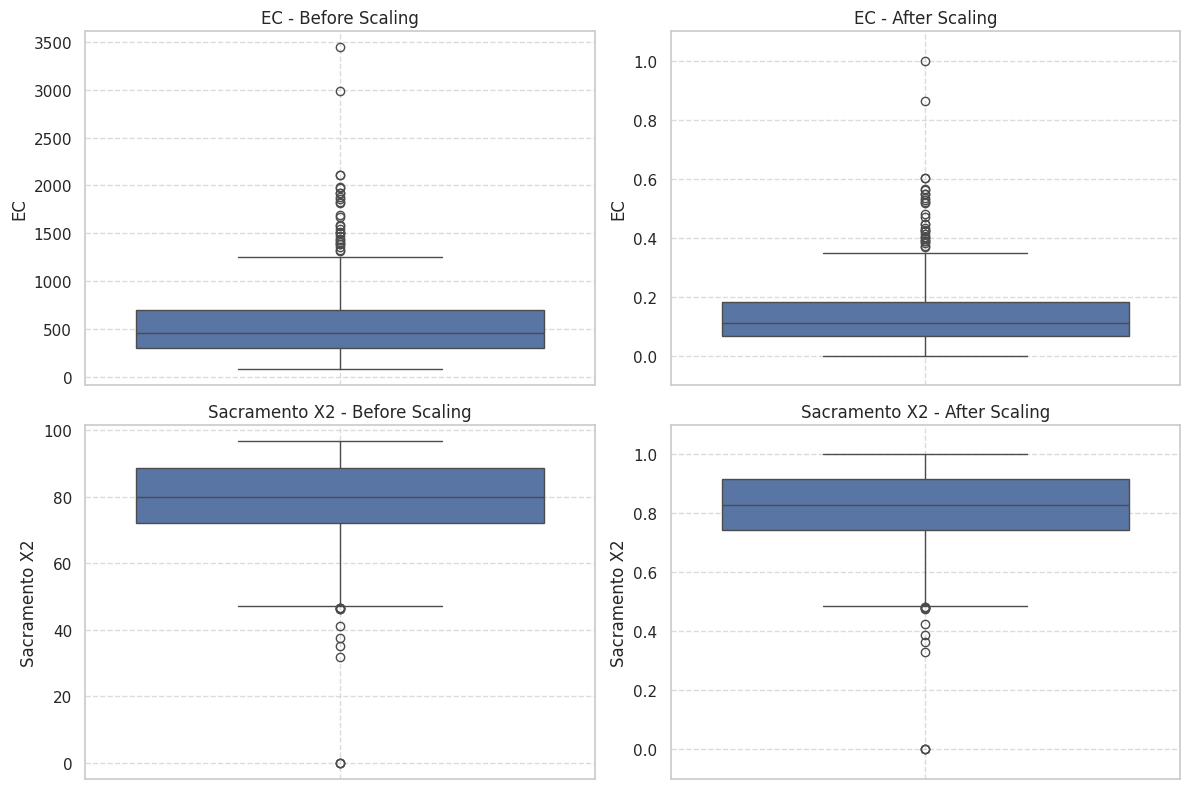

Preprocessor saved to /content/drive/MyDrive/Gitea/outputs/Br_preprocessor.joblib


In [ ]:
# ================= PREPROCESSING =================

# Make sure the output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created output directory: {output_folder}")

# Change this to analyze different ions (Br, Ca, Cl, K, Mg, Na, SO4, TDS, Alkalinity)
TARGET_ION = 'Br'

# Get the target dataframe based on the ion name
df = ion_dfs[TARGET_ION]

# Extract month from Collection Date for seasonality information
df['Month'] = pd.to_datetime(df['Collection Date']).dt.strftime('%b')  # Convert to month abbreviation (Jan, Feb, etc.)

# Define our features
numerical_features = ['EC', 'Sacramento X2']
categorical_features = ['Location', 'WYT', 'Month']
target = TARGET_ION  # The ion concentration we want to predict

# Split data into features (X) and target (y)
X = df.drop(columns=[TARGET_ION])
y = df[TARGET_ION]

# Create preprocessing steps for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(0, 1)))  # Scale features between 0 and 1
])

# Create preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # One-hot encode with dropping first category
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep other columns
)

# Apply preprocessing to the data
X_preprocessed = preprocessor.fit_transform(X)

# Get the feature names after transformation
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = []
for i, feature in enumerate(categorical_features):
    feature_categories = ohe.categories_[i][1:]  # Skip the first category (dropped)
    categorical_feature_names.extend([f"{feature}_{category}" for category in feature_categories])

# Combine all feature names
transformed_column_names = numerical_features + categorical_feature_names
remainder_columns = [col for col in X.columns if col not in numerical_features + categorical_features]
all_column_names = transformed_column_names + remainder_columns

# Create a DataFrame with the preprocessed data for easier visualization
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_column_names)

# Visualize the effect of scaling on numerical features
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 4*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    # Before preprocessing
    sns.boxplot(y=X[feature], ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} - Before Scaling')
    axes[i, 0].grid(True, linestyle='--', alpha=0.7)

    # After preprocessing
    sns.boxplot(y=X_preprocessed_df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} - After Scaling')
    axes[i, 1].grid(True, linestyle='--', alpha=0.7)
    axes[i, 1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, f"{TARGET_ION}_numerical_before_after_comparison.png"))
plt.show()

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Save the preprocessing pipeline for later use
preprocessor_path = os.path.join(output_folder, f'{TARGET_ION}_preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to {preprocessor_path}")

In [ ]:
X.head(3)

,Long Station Name,Collection Date,EC,Sacramento X2,Location,WYT,Month
0,Rock Slough @ Old River,1990-01-24,962.0,79.667207,OMR,C,Jan
1,Clifton Court Intake,1990-02-21,472.0,80.129967,OMR,C,Feb
2,Rock Slough @ Old River,1990-02-23,598.0,83.082526,OMR,C,Feb


In [ ]:
X_preprocessed_df.head(3)

,EC,Sacramento X2,Location_SJRcorridor,Location_SouthDelta,WYT_BN,WYT_C,WYT_D,WYT_W,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Long Station Name,Collection Date
0,0.262748,0.823784,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock Slough @ Old River,1990-01-24
1,0.11714,0.828569,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Clifton Court Intake,1990-02-21
2,0.154582,0.8591,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock Slough @ Old River,1990-02-23


## 4. Model Training

In [ ]:
# ================= MODEL TRAINING =================
# Load the preprocessing pipeline
preprocessor_path = os.path.join(output_folder, f'{TARGET_ION}_preprocessor.joblib')
print(f"Loading preprocessor from {preprocessor_path}")
preprocessor = joblib.load(preprocessor_path)

# Apply preprocessing to the training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the processed feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = []
for i, feature in enumerate(categorical_features):
    feature_categories = ohe.categories_[i][1:]  # Skip the first category (dropped)
    categorical_feature_names.extend([f"{feature}_{category}" for category in feature_categories])

# Create column names for the transformed dataframe
transformed_column_names = numerical_features + categorical_feature_names
remainder_columns = [col for col in X_train.columns if col not in numerical_features + categorical_features]

# Create dataframes with the transformed data
X_train_processed_df = pd.DataFrame(
    X_train_processed,
    columns=transformed_column_names + remainder_columns
)

X_test_processed_df = pd.DataFrame(
    X_test_processed,
    columns=transformed_column_names + remainder_columns
)

# Keep only the numerical and categorical columns for training models
X_train_processed_filtered = X_train_processed_df[transformed_column_names].values.astype(np.float32)
X_test_processed_filtered = X_test_processed_df[transformed_column_names].values.astype(np.float32)

print(f"Training data shape: {X_train_processed_filtered.shape}")
print(f"Features used for model training: {transformed_column_names}")

# ================= MODEL 1: RANDOM FOREST =================
print(f"\nTraining Random Forest for {TARGET_ION}...")

# Create and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_processed_filtered, y_train)

# Save the Random Forest model
rf_model_path = os.path.join(output_folder, f'{TARGET_ION}_random_forest_model.joblib')
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")

# ================= MODEL 2: XGBOOST =================
print(f"\nTraining XGBoost for {TARGET_ION}...")

# Create and train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_processed_filtered, y_train)

# Save the XGBoost model
xgb_model_path = os.path.join(output_folder, f'{TARGET_ION}_xgboost_model.joblib')
joblib.dump(xgb_model, xgb_model_path)
print(f"XGBoost model saved to {xgb_model_path}")

# ================= MODEL 3: NEURAL NETWORK =================
print(f"\nTraining Neural Network for {TARGET_ION}...")

# Get the number of input features from the filtered data
num_features = X_train_processed_filtered.shape[1]

# Create a neural network model
nn_model = Sequential([
    # Input layer
    Dense(128, activation='relu', input_shape=(num_features,)),
    # Hidden layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Output layer
    Dense(1)  # No activation for regression
])

# Compile the model
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model
nn_model.fit(
    X_train_processed_filtered,
    y_train.values.astype(np.float32),
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Save the Neural Network model
nn_model_path = os.path.join(output_folder, f'{TARGET_ION}_nn_model.h5')
nn_model.save(nn_model_path)
print(f"Neural Network model saved to {nn_model_path}")

# Save the feature names for future reference
feature_names_path = os.path.join(output_folder, f'{TARGET_ION}_model_feature_names.joblib')
joblib.dump(transformed_column_names, feature_names_path)
print(f"Feature names saved to {feature_names_path}")

print(f"\nAll models for {TARGET_ION} have been trained and saved successfully!")

Loading preprocessor from /content/drive/MyDrive/Gitea/outputs/Br_preprocessor.joblib
Training data shape: (991, 19)
Features used for model training: ['EC', 'Sacramento X2', 'Location_SJRcorridor', 'Location_SouthDelta', 'WYT_BN', 'WYT_C', 'WYT_D', 'WYT_W', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']

Training Random Forest for Br...
Random Forest model saved to /content/drive/MyDrive/Gitea/outputs/Br_random_forest_model.joblib

Training XGBoost for Br...
XGBoost model saved to /content/drive/MyDrive/Gitea/outputs/Br_xgboost_model.joblib

Training Neural Network for Br...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0586 - val_loss: 0.0348
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0446 - val_loss: 0.0286
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0291 - val_loss: 0.0236
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 - val_loss: 0.0170
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

Neural Network model saved to /content/drive/MyDrive/Gitea/outputs/Br_nn_model.h5
Feature names saved to /content/drive/MyDrive/Gitea/outputs/Br_model_feature_names.joblib

All models for Br have been trained and saved successfully!


## 5. Evaluation

Loading models and data from /content/drive/MyDrive/Gitea/outputs


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model Evaluation Results:
            Model   Dataset   MAE  Percentage Bias    R2
0   Random Forest  Training  0.01             1.47  0.99
1   Random Forest      Test  0.03             1.49  0.95
2         XGBoost  Training  0.02             3.42  0.99
3         XGBoost      Test  0.03             3.57  0.96
4  Neural Network  Training  0.02             7.05  0.97
5  Neural Network      Test  0.03             5.97  0.96
Evaluation results saved to /content/drive/MyDrive/Gitea/outputs/Br_model_evaluation.csv
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model comparison plot saved to /content/drive/MyDrive/Gitea/outputs/Br_model_comparison.png


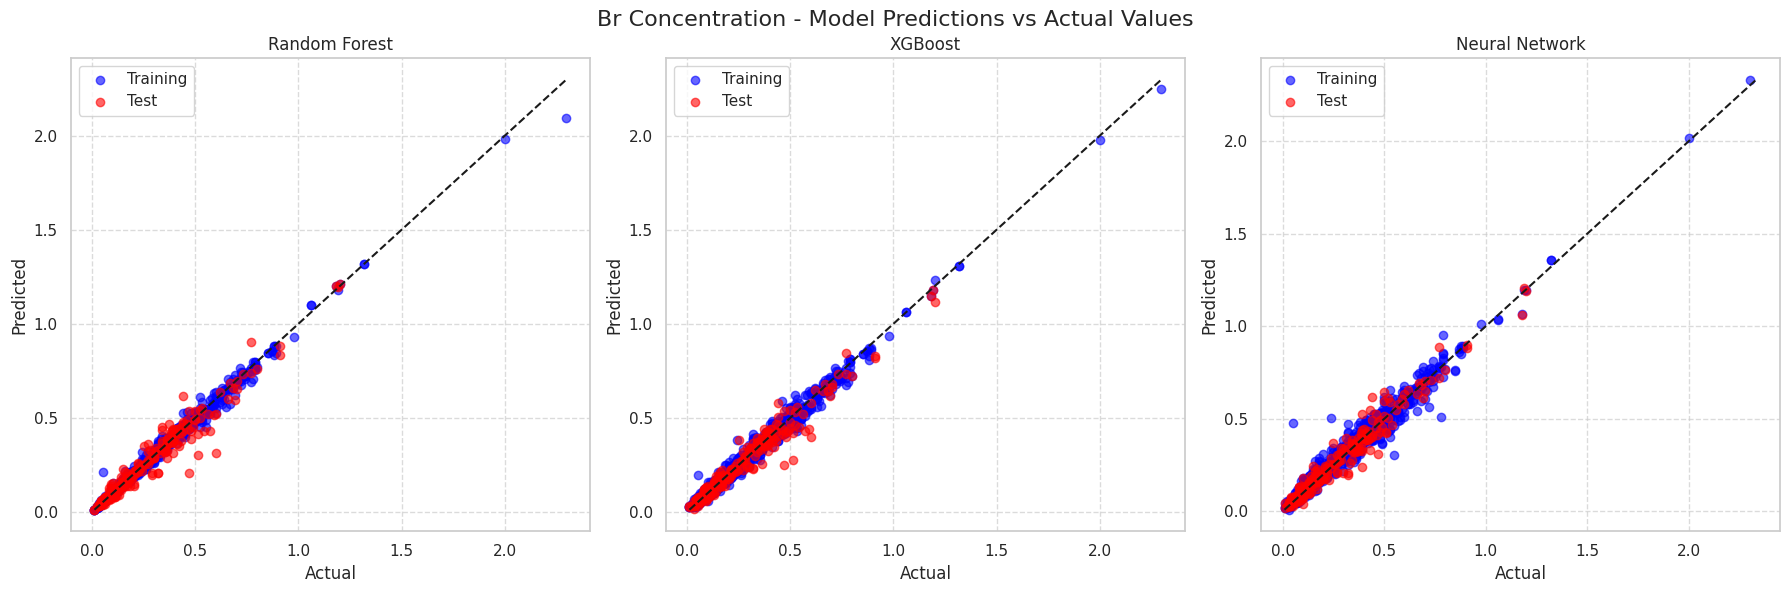

Performance metrics plot saved to /content/drive/MyDrive/Gitea/outputs/Br_model_performance_metrics.png


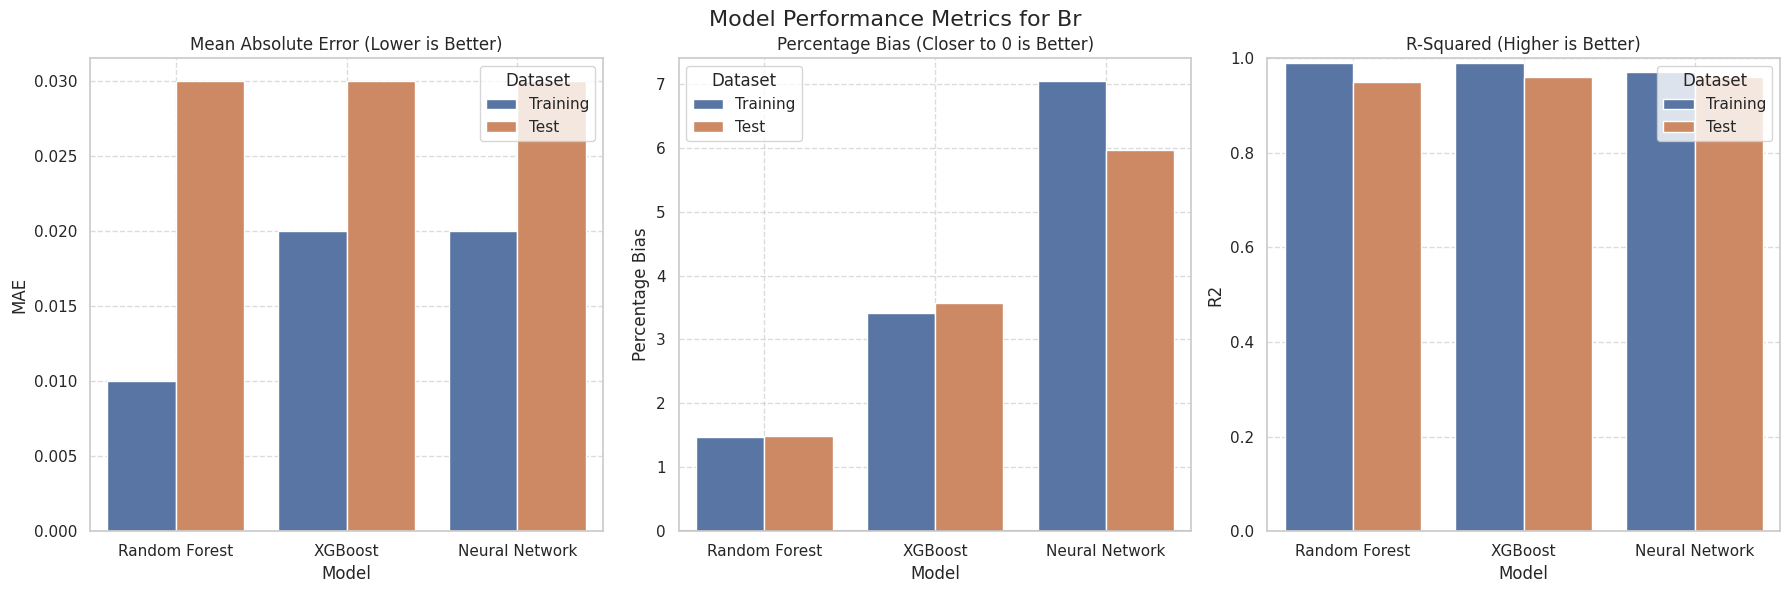

In [ ]:
# ================= MODEL EVALUATION =================
# Load the preprocessor, feature names, and models
preprocessor_path = os.path.join(output_folder, f'{TARGET_ION}_preprocessor.joblib')
feature_names_path = os.path.join(output_folder, f'{TARGET_ION}_model_feature_names.joblib')
rf_model_path = os.path.join(output_folder, f'{TARGET_ION}_random_forest_model.joblib')
xgb_model_path = os.path.join(output_folder, f'{TARGET_ION}_xgboost_model.joblib')
nn_model_path = os.path.join(output_folder, f'{TARGET_ION}_nn_model.h5')

print(f"Loading models and data from {output_folder}")
preprocessor = joblib.load(preprocessor_path)
feature_names = joblib.load(feature_names_path)

# Load the trained models
rf_model = joblib.load(rf_model_path)
xgb_model = joblib.load(xgb_model_path)
nn_model = load_model(nn_model_path)

# Apply preprocessing to the training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Create dataframes with the transformed data
X_train_processed_df = pd.DataFrame(
    X_train_processed,
    columns=feature_names + [col for col in X_train.columns if col not in numerical_features + categorical_features]
)

X_test_processed_df = pd.DataFrame(
    X_test_processed,
    columns=feature_names + [col for col in X_test.columns if col not in numerical_features + categorical_features]
)

# Keep only the features used for model training
X_train_filtered = X_train_processed_df[feature_names].values.astype(np.float32)
X_test_filtered = X_test_processed_df[feature_names].values.astype(np.float32)

# Define a function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    """Calculate MAE, percentage bias, and R2 score"""
    mae = mean_absolute_error(y_true, y_pred)
    percent_bias = np.mean((y_pred - y_true) / y_true) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, percent_bias, r2

# Make predictions for each model
models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Neural Network': nn_model
}

# Calculate metrics for each model
results = []
for name, model in models.items():
    # Make predictions
    if name == 'Neural Network':
        y_train_pred = model.predict(X_train_filtered).flatten()
        y_test_pred = model.predict(X_test_filtered).flatten()
    else:
        y_train_pred = model.predict(X_train_filtered)
        y_test_pred = model.predict(X_test_filtered)

    # Calculate metrics
    train_mae, train_bias, train_r2 = calculate_metrics(y_train, y_train_pred)
    test_mae, test_bias, test_r2 = calculate_metrics(y_test, y_test_pred)

    # Store results
    results.append({
        'Model': name,
        'Dataset': 'Training',
        'MAE': round(train_mae, 2),
        'Percentage Bias': round(train_bias, 2),
        'R2': round(train_r2, 2)
    })

    results.append({
        'Model': name,
        'Dataset': 'Test',
        'MAE': round(test_mae, 2),
        'Percentage Bias': round(test_bias, 2),
        'R2': round(test_r2, 2)
    })

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display results
print("Model Evaluation Results:")
print(results_df)

# Save evaluation results
results_csv_path = os.path.join(output_folder, f'{TARGET_ION}_model_evaluation.csv')
results_df.to_csv(results_csv_path, index=False)
print(f"Evaluation results saved to {results_csv_path}")

# Create a comparison plot for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'{TARGET_ION} Concentration - Model Predictions vs Actual Values', fontsize=16)

# Create scatter plots to compare predicted vs actual values
for i, (name, model) in enumerate(models.items()):
    # Get predictions for both training and test sets
    if name == 'Neural Network':
        y_train_pred = model.predict(X_train_filtered).flatten()
        y_test_pred = model.predict(X_test_filtered).flatten()
    else:
        y_train_pred = model.predict(X_train_filtered)
        y_test_pred = model.predict(X_test_filtered)

    # Create scatter plot with blue for training and red for test
    axes[i].scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training')
    axes[i].scatter(y_test, y_test_pred, alpha=0.6, color='red', label='Test')

    # Add perfect prediction line
    min_val = min(min(y_train.min(), y_train_pred.min()), min(y_test.min(), y_test_pred.min()))
    max_val = max(max(y_train.max(), y_train_pred.max()), max(y_test.max(), y_test_pred.max()))
    axes[i].plot([min_val, max_val], [min_val, max_val], 'k--')

    # Set labels and title
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
comparison_plot_path = os.path.join(output_folder, f"{TARGET_ION}_model_comparison.png")
plt.savefig(comparison_plot_path)
print(f"Model comparison plot saved to {comparison_plot_path}")
plt.show()

# Visualize the metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Model Performance Metrics for {TARGET_ION}', fontsize=16)

# 1. MAE - Mean Absolute Error (lower is better)
sns.barplot(x='Model', y='MAE', hue='Dataset', data=results_df, ax=axes[0])
axes[0].set_title('Mean Absolute Error (Lower is Better)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# 2. Bias - Percentage Bias (closer to 0 is better)
sns.barplot(x='Model', y='Percentage Bias', hue='Dataset', data=results_df, ax=axes[1])
axes[1].set_title('Percentage Bias (Closer to 0 is Better)')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 3. R² - R-Squared (higher is better)
sns.barplot(x='Model', y='R2', hue='Dataset', data=results_df, ax=axes[2])
axes[2].set_title('R-Squared (Higher is Better)')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
metrics_plot_path = os.path.join(output_folder, f'{TARGET_ION}_model_performance_metrics.png')
plt.savefig(metrics_plot_path, dpi=300, bbox_inches='tight')
print(f"Performance metrics plot saved to {metrics_plot_path}")
plt.show()

## 6. Dashboard

In [ ]:
# ================= INTERACTIVE DASHBOARD =================

# Make sure Panel and hvPlot are installed
try:
    import panel as pn
    import hvplot.pandas
    import holoviews as hv
except ImportError:
    print("Installing required packages...")
    !pip install panel hvplot
    import panel as pn
    import hvplot.pandas
    import holoviews as hv

# Initialize Panel extension for interactive dashboard
pn.extension()

# Define custom style for widgets
widget_style = {
    'background': '#f9f9f9',
    'border': '1px solid #ddd',
    'padding': '10px',
    'border-radius': '5px'
}

# Define location names for display
location_names = {
    'OMR': 'Old River at Old River',
    'SJRcorridor': 'San Joaquin River at Jersey Point',
    'SouthDelta': 'Middle River at Middle River'
}

# Function to make predictions
def predict_ion_concentration(ec, sacramento_x2, location, wyt, month):
    """Make predictions using all three models"""
    try:
        # Create a DataFrame with input values
        input_data = pd.DataFrame({
            'EC': [ec],
            'Sacramento X2': [sacramento_x2],
            'Location': [location],
            'WYT': [wyt],
            'Month': [month],
            'Collection Date': [f"2023-{datetime.strptime(month, '%b').month:02d}-15"],
            'Long Station Name': [location_names.get(location, "Unknown")]
        })

        # Load and apply preprocessor
        preprocessor_path = os.path.join(output_folder, f'{TARGET_ION}_preprocessor.joblib')
        preprocessor = joblib.load(preprocessor_path)
        X_processed = preprocessor.transform(input_data)

        # Get feature names and filter processed data
        feature_names_path = os.path.join(output_folder, f'{TARGET_ION}_model_feature_names.joblib')
        feature_names = joblib.load(feature_names_path)
        X_filtered = pd.DataFrame(X_processed, columns=feature_names +
                                [col for col in input_data.columns
                                 if col not in numerical_features + categorical_features])
        X_filtered = X_filtered[feature_names].values.astype(np.float32)

        # Load models
        rf_model_path = os.path.join(output_folder, f'{TARGET_ION}_random_forest_model.joblib')
        xgb_model_path = os.path.join(output_folder, f'{TARGET_ION}_xgboost_model.joblib')
        nn_model_path = os.path.join(output_folder, f'{TARGET_ION}_nn_model.h5')

        rf_model = joblib.load(rf_model_path)
        xgb_model = joblib.load(xgb_model_path)
        nn_model = load_model(nn_model_path)

        # Make predictions
        rf_pred = rf_model.predict(X_filtered)[0]
        xgb_pred = xgb_model.predict(X_filtered)[0]
        nn_pred = nn_model.predict(X_filtered).flatten()[0]

        return {
            'Random Forest': rf_pred,
            'XGBoost': xgb_pred,
            'Neural Network': nn_pred
        }
    except Exception as e:
        print(f"Error in prediction: {e}")
        return {
            'Random Forest': np.nan,
            'XGBoost': np.nan,
            'Neural Network': np.nan
        }

# Create input widgets
ec_slider = pn.widgets.FloatSlider(
    name='Electrical Conductivity (EC) [µS/cm]',
    start=100,
    end=3500,
    value=1000,
    step=10,
    styles=widget_style
)

sacramento_x2_slider = pn.widgets.FloatSlider(
    name='Sacramento X2',
    start=40,
    end=100,
    value=80,
    step=1,
    styles=widget_style
)

location_select = pn.widgets.Select(
    name='Location',
    options=['OMR', 'SJRcorridor', 'SouthDelta'],
    value='OMR',
    styles=widget_style
)

wyt_select = pn.widgets.Select(
    name='Water Year Type (WYT)',
    options=['W', 'AN', 'BN', 'D', 'C'],
    value='AN',
    styles=widget_style
)

month_select = pn.widgets.Select(
    name='Month',
    options=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    value='Sep',
    styles=widget_style
)

# Output components
prediction_table = pn.pane.HTML(width=500, height=200)
prediction_plot = pn.pane.HoloViews()
status_message = pn.pane.Markdown("Ready to predict", styles={'color': 'blue'})

# Function to update predictions when inputs change
def update_predictions(event):
    # Update status
    status_message.object = "Calculating predictions..."

    # Get input values
    ec = ec_slider.value
    sacramento_x2 = sacramento_x2_slider.value
    location = location_select.value
    wyt = wyt_select.value
    month = month_select.value

    # Make predictions
    predictions = predict_ion_concentration(ec, sacramento_x2, location, wyt, month)

    # Update table
    html_table = f"""
    <div style="background: #f9f9f9; border: 1px solid #ddd; padding: 15px; border-radius: 5px;">
      <h3>Predicted {TARGET_ION} Concentration</h3>
      <table style="width: 100%; border-collapse: collapse;">
        <tr>
          <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
          <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">{TARGET_ION} (mg/L)</th>
        </tr>
        <tr>
          <td style="text-align: left; padding: 8px; border-bottom: 1px solid #ddd;">Random Forest</td>
          <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">{predictions['Random Forest']:.2f}</td>
        </tr>
        <tr>
          <td style="text-align: left; padding: 8px; border-bottom: 1px solid #ddd;">XGBoost</td>
          <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">{predictions['XGBoost']:.2f}</td>
        </tr>
        <tr>
          <td style="text-align: left; padding: 8px; border-bottom: 1px solid #ddd;">Neural Network</td>
          <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">{predictions['Neural Network']:.2f}</td>
        </tr>
      </table>
    </div>
    """
    prediction_table.object = html_table

    # Create bar chart
    result_df = pd.DataFrame({
        'Model': list(predictions.keys()),
        'Prediction': list(predictions.values())
    })

    # Define specific colors for each model
    model_colors = {
        'Random Forest': '#1f77b4',  # blue
        'XGBoost': '#ff7f0e',        # orange
        'Neural Network': '#2ca02c'   # green
    }

    bar_chart = result_df.hvplot.bar(
        x='Model',
        y='Prediction',
        color='Model',
        cmap=model_colors,  # Use the custom color mapping
        ylim=(0, None),
        ylabel=f'{TARGET_ION} Concentration (mg/L)',
        title=f'Predicted {TARGET_ION} for {location}, {month}, WYT: {wyt}',
        height=400,
        width=600
    )

    prediction_plot.object = bar_chart
    status_message.object = "Predictions updated"

# Connect input changes to updates
for widget in [ec_slider, sacramento_x2_slider, location_select, wyt_select, month_select]:
    widget.param.watch(update_predictions, 'value')

# Create dashboard title and description
title = pn.pane.Markdown(f"""
# {TARGET_ION} Concentration Prediction Dashboard

This dashboard uses three machine learning models to predict {TARGET_ION} concentration based on
environmental parameters. Adjust the sliders and dropdown menus to see how different conditions
affect predicted {TARGET_ION} levels.
""")

# Create information panel
info_panel = pn.pane.Markdown("""
### Parameter Information

- **Electrical Conductivity (EC)**: Measure of water's ability to conduct electricity, related to dissolved ions. Units: μS/cm.
- **Sacramento X2**: Distance from Golden Gate Bridge to the location where salinity is 2 parts per thousand.
- **Location**: Monitoring station in the Delta.
- **Water Year Type (WYT)**: Classification of water conditions:
  - W: Wet
  - AN: Above Normal
  - BN: Below Normal
  - D: Dry
  - C: Critical
- **Month**: Time of year for prediction.
""")

# Publicly available dashboards info
dashboards_info = pn.pane.Markdown("""
### Our Publicly Available Dashboards

| Dashboard | ID | Web Link |
|-----------|-------|---------|
| Interior Delta Dashboard | DD1 | [https://dwrdashion.azurewebsites.net/Dashboard](https://dwrdashion.azurewebsites.net/Dashboard) |
| Interpretability Dashboard | DD2 | [https://dwrdashionsensitivity.azurewebsites.net/Sensitivity_IonStudy](https://dwrdashionsensitivity.azurewebsites.net/Sensitivity_IonStudy) |
| Water Intake Locations Dashboard | DD3 | [https://dwrdashionintake.azurewebsites.net/Intake_dashboard](https://dwrdashionintake.azurewebsites.net/Intake_dashboard) |
""", styles={'background': '#f0f0f0', 'padding': '10px', 'border-radius': '5px', 'margin-top': '20px'})

# Footer with disclaimer
footer = pn.pane.Markdown("""
---
**Disclaimer:** This dashboard is for educational purposes only. Predictions are based on models trained
with historical data and may not reflect current or future conditions.

*Created as part of the Machine Learning Workshop*
""")

# Contact information
contact_info = pn.pane.Markdown("""
---
**For questions or feedback, please contact:**
Peyman Namadi (peyman.hosseinzadehnamadi@water.ca.gov)
Kevin He (kevin.he@water.ca.gov)
""", styles={'font-size': '14px', 'margin-top': '20px'})

# Create dashboard layout
dashboard = pn.Column(
    title,
    pn.Row(
        # Inputs panel
        pn.Column(
            pn.pane.Markdown("### Input Parameters"),
            ec_slider,
            sacramento_x2_slider,
            location_select,
            wyt_select,
            month_select,
            status_message,
            width=350
        ),
        # Results panel
        pn.Column(
            pn.pane.Markdown("### Prediction Results"),
            prediction_table,
            prediction_plot,
            width=650
        ),
    ),
    pn.Row(
        pn.Column(info_panel, width=1000)
    ),
    dashboards_info,
    footer,
    contact_info
)

# Display the dashboard
dashboard.show()  # Changed from show() to servable() for Colab

# Trigger initial prediction
update_predictions(None)
dashboard

Launching server at http://localhost:42701


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Column
    [0] Markdown(str)
    [1] Row
        [0] Column(width=350)
            [0] Markdown(str)
            [1] FloatSlider(end=3500, name='Electrical Conductivity (..., start=100, step=10, styles={'background': '#f9f9f9', ...}, value=1000)
            [2] FloatSlider(end=100, name='Sacramento X2', start=40, step=1, styles={'background': '#f9f9f9', ...}, value=80)
            [3] Select(name='Location', options=['OMR', 'SJRcorridor', ...], styles={'background': '#f9f9f9', ...}, value='OMR')
            [4] Select(name='Water Year Type (WYT)', options=['W', 'AN', 'BN', ...], styles={'background': '#f9f9f9', ...}, value='AN')
            [5] Select(name='Month', options=['Jan', 'Feb', ...], styles={'background': '#f9f9f9', ...}, value='Sep')
            [6] Markdown(str, styles={'color': 'blue'})
        [1] Column(width=650)
            [0] Markdown(str)
            [1] HTML(str, height=200, sizing_mode='fixed', width=500)
            [2] HoloViews(Bars, height=400, sizing_mode='fixed', width=600)
    [2] Row
        [0] Column(width=1000)
            [0] Markdown(str)
    [3] Markdown(str, styles={'background': '#f0f0f0', ...})
    [4] Markdown(str)
    [5] Markdown(str, styles={'font-size': '14px', ...})